# Calcule somme des ventes

## 1. Depuis un fichier CSV

### 1.1. Configuration de l'environnement Spark

In [1]:
!~/miniconda3/bin/pip install pyspark

In [2]:
import pyspark

In [3]:
import pandas as pd
pd.read_csv('ventes.csv')

,date,city,product,price
0,2019-02-10,Marrakech,TV,1000
1,2019-02-10,Lyon,Phone,500
2,2019-02-10,Marseille,TV,1000
3,2019-02-10,Marrakech,Phone,500
4,2019-02-10,Marrakech,TV,1000
5,2019-02-10,Lyon,TV,1000
6,2019-02-10,Marseille,Phone,500
7,2019-02-10,Marrakech,Phone,500


### 1.2. Import du CSV

In [4]:
from pyspark.sql import SparkSession

In [10]:
spark=SparkSession.builder.appName('ventes').getOrCreate()

In [6]:
spark

In [7]:
df_pyspark=spark.read.csv('file:///home/aya/ventes.csv', header=True)

In [8]:
df_pyspark.show()

+----------+---------+-------+-----+
|      date|     city|product|price|
+----------+---------+-------+-----+
|2019-02-10|Marrakech|     TV| 1000|
|2019-02-10|     Lyon|  Phone| 500 |
|2019-02-10|Marseille|     TV| 1000|
|2019-02-10|Marrakech|  Phone|  500|
|2019-02-10|Marrakech|     TV| 1000|
|2019-02-10|     Lyon|     TV| 1000|
|2019-02-10|Marseille|  Phone|  500|
|2019-02-10|Marrakech|  Phone|  500|
+----------+---------+-------+-----+



In [9]:
df_pyspark.printSchema()

root
 |-- date: string (nullable = true)
 |-- city: string (nullable = true)
 |-- product: string (nullable = true)
 |-- price: string (nullable = true)



On voit bien que les types des colonnes n'ont pas été correctement interprétés ! On utilisera alors **inferSchema** :

In [11]:
df_pyspark=spark.read.csv('file:///home/aya/ventes.csv', header=True, inferSchema=True)
df_pyspark.printSchema()

root
 |-- date: date (nullable = true)
 |-- city: string (nullable = true)
 |-- product: string (nullable = true)
 |-- price: double (nullable = true)



### 1.3. Calcule de la somme des ventes

In [12]:
df_cityprice=df_pyspark.select(['city','price'])
df_cityprice.show()

+---------+------+
|     city| price|
+---------+------+
|Marrakech|1000.0|
|     Lyon| 500.0|
|Marseille|1000.0|
|Marrakech| 500.0|
|Marrakech|1000.0|
|     Lyon|1000.0|
|Marseille| 500.0|
|Marrakech| 500.0|
+---------+------+



In [13]:
dfProductCount=df_cityprice.groupBy("city").sum()

In [14]:
dfProductCount.show()

+---------+----------+
|     city|sum(price)|
+---------+----------+
|Marseille|    1500.0|
|     Lyon|    1500.0|
|Marrakech|    3000.0|
+---------+----------+



## 2. Depuis un stream

### 2.1. Import des librairie et initialisation

In [ ]:
from pyspark.streaming import StreamingContext

from pyspark.sql.functions import split  # convertir convertir une ligne en colonne
from pyspark.sql.functions import explode  # convertir colonne vers ligne

from pyspark.sql.functions import col
from pyspark.sql.functions import sum

In [16]:
dfLines = spark.readStream.format("socket").option("host", "localhost").option("port", 8080).load()

23/04/25 01:35:09 WARN TextSocketSourceProvider: The socket source should not be used for production applications! It does not support recovery.


On suppose que les données seront séparés par un espace " "

In [17]:
dfVentes = dfLines.select(split(dfLines["value"], " ").alias("ventes"))

df_pair = dfVentes.select(dfVentes["ventes"][1].alias("city"), dfVentes["ventes"][3].alias("price"))
df_pair=df_pair.withColumn("price",col("price").cast('double')).groupBy("city").sum()

df_pair.printSchema()


root
 |-- city: string (nullable = true)
 |-- sum(price): double (nullable = true)



In [ ]:
df_pair.writeStream.format("console").outputMode("update").trigger(processingTime='6 seconds').start().awaitTermination()

23/04/25 01:37:00 WARN ResolveWriteToStream: Temporary checkpoint location created which is deleted normally when the query didn't fail: /tmp/temporary-5b265911-1975-4db0-b631-0c5e7959b3c3. If it's required to delete it under any circumstances, please set spark.sql.streaming.forceDeleteTempCheckpointLocation to true. Important to know deleting temp checkpoint folder is best effort.
23/04/25 01:37:00 WARN ResolveWriteToStream: spark.sql.adaptive.enabled is not supported in streaming DataFrames/Datasets and will be disabled.


-------------------------------------------
Batch: 0
-------------------------------------------
+----+----------+
|city|sum(price)|
+----+----------+
+----+----------+



23/04/25 01:37:08 WARN ProcessingTimeExecutor: Current batch is falling behind. The trigger interval is 6000 milliseconds, but spent 8892 milliseconds


-------------------------------------------
Batch: 5
-------------------------------------------
+---------+----------+
|     city|sum(price)|
+---------+----------+
|marseille|    8522.2|
+---------+----------+



23/04/25 01:37:19 WARN ProcessingTimeExecutor: Current batch is falling behind. The trigger interval is 6000 milliseconds, but spent 7009 milliseconds


-------------------------------------------
Batch: 6
-------------------------------------------
+---------+----------+
|     city|sum(price)|
+---------+----------+
|marrakech|   45000.0|
+---------+----------+



23/04/25 01:37:37 WARN ProcessingTimeExecutor: Current batch is falling behind. The trigger interval is 6000 milliseconds, but spent 7004 milliseconds
23/04/25 01:38:05 WARN TextSocketMicroBatchStream: Stream closed by localhost:8080


Voici les inputs : (les 4 premiers sont des tests)
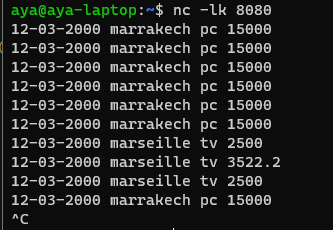

---